# Lab 2: Deep Q-Network implementation.

PyTorch debug mode

This homework shamelessly demands you to implement a DQN - an approximate q-learning algorithm with experience replay and target networks - and see if it works any better this way.

Original paper:
https://arxiv.org/pdf/1312.5602.pdf

**This notebook is given for debug.** The main DQN task will be in the same folder later. The tasks are similar and share most of the code. The main difference is in environments. In main notebook it can take some 2 hours for the agent to start improving so it seems reasonable to launch the algorithm on a simpler env first. Here it is CartPole and it will train in several minutes.

**We suggest the following pipeline:** First implement debug notebook then implement the main one.

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for pytoch, but you find it easy to adapt it to almost any python-based deep learning framework.

In [1]:
import re
import glob
import random
import time
import math
from tqdm import tqdm

import numpy as np
import torch

import gym

import seaborn as sns
import matplotlib.pyplot as plt

import utils
from IPython.display import Video, clear_output

plt.style.use("seaborn")

In [2]:
ENV_NAME = 'CartPole-v1'
#ENV_NAME = 'MountainCar-v0'
#ENV_NAME = 'MountainCarContinuous-v0'

def make_env(seed=None):
    # CartPole is wrapped with a time limit wrapper by default
    env = gym.make(ENV_NAME).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

In [3]:
env = make_env()
env.reset()
state_shape, n_actions = env.observation_space.shape, env.action_space.n
print(state_shape)
print(n_actions)

(4,)
2


In [4]:
print(env.__doc__)


    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.

    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson

    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf

    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right

        Note: The amount the velocity that is reduced

# Play yourself

# Support functions

In [5]:
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [6]:
def disable_view_window():
    from gym.envs.classic_control import rendering
    org_constructor = rendering.Viewer.__init__

    def constructor(self, *args, **kwargs):
        org_constructor(self, *args, **kwargs)
        self.window.set_visible(visible=False)

    rendering.Viewer.__init__ = constructor
disable_view_window()

In [7]:
def show_run(video_folder, rewards, idx=None, best=False, worse=False):

    assert idx == None or (best == False and worse == False), "both idx and best / worse are specified"
    assert best == False or worse == False, "both flags are up"
    
    runs = natural_sort(glob.glob(video_folder + "**/" + "*.mp4"))
    
    assert len(runs) == len(rewards), f"different number of files ({len(runs)})  and rewards ({len(rewards)})"
    
    if best:
        idx = np.argmax(rewards)
    elif worse:
        idx = np.argmin(rewards)
    elif idx == None:
        idx = random.randint(0, len(runs) - 1)
        
    run = runs[idx]
    reward = rewards[idx]
    
    print(f"displaying '{run}' run")
    print(f"reward: {reward}")
    display(Video(run, html_attributes="controls loop autoplay"))

In [8]:
def play_game(env, policy, reward_discount=1.0, max_steps=np.inf, render=False, sleep=0.01, video_folder=None):
    
    if video_folder is not None:
        env = gym.wrappers.RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: True)
    
    state = env.reset()
    iter_reward = 0
    cur_step = 0
    done = False

    while not done and cur_step < max_steps:
        
        action = policy.get_action(state)
        state, reward, done, _ = env.step(action)
        iter_reward += reward * math.pow(reward_discount, cur_step)
        cur_step += 1
        
        if render:
            clear_output(wait=True)
            plt.imshow(env.render("rgb_array"))
            plt.show()

    return iter_reward

In [9]:
def eval_policy(env, policy, n_iter=200, max_steps=np.inf, video_folder=None, verbose=True):

    rewards = np.zeros(n_iter)
    #if video_folder is not None:
        #env = gym.wrappers.RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: True)
    #if video_folder is not None:
    
    for i in tqdm(range(n_iter), disable=not verbose):
        
        if video_folder is not None:
            rewards[i] = play_game(env, policy, max_steps=max_steps, video_folder=video_folder+str(i)+"/")
        else:
            rewards[i] = play_game(env, policy, max_steps=max_steps)
        
    return rewards

In [10]:
def analyze_policy(env, policy, n_iter=200, n_iter_record=30, max_steps=np.inf, video_folder="./runs/"):

    rewards = eval_policy(env, policy, n_iter=n_iter, max_steps=max_steps)
    
    sns.boxplot(x=rewards)
    plt.title("reward distribution")
    plt.show()
    
    video_folder = video_folder + type(policy).__name__ + '/'
    rewards = eval_policy(env, policy, n_iter=n_iter_record, max_steps=max_steps, video_folder=video_folder)
    
    print(f"Best run (out of {n_iter_record} sampled):")
    show_run(video_folder, rewards, best=True)
    
    return video_folder, rewards

## Random strategy

## Angle Policy

## Cross-entropy strategy

In [11]:
class CrossEntropy:
    
    def __init__(self, env, input_size, out_size, hid_size=16):
        
        self.env = env
        self.W1 = np.zeros((input_size, hid_size))
        self.W2 = np.zeros((hid_size, out_size))
        
    @property
    def number_of_weights(self):
        return len(self.W1.flatten()) + len(self.W2.flatten())
        
    def set_weights(self, weights):
        self.W1 = weights[:len(self.W1.flatten())].reshape(self.W1.shape)
        self.W2 = weights[len(self.W1.flatten()):].reshape(self.W2.shape)
    
    def forward(self, state):
        state = np.array(state)
        x = state.T @ self.W1
        x = x.T @ self.W2
        return x
    
    def get_action(self, state):
        return np.argmax(self.forward(state))
    
    def train(self, cohort_len=100, max_steps=200, elite_percentile=0.9, reward_threshold=190, n_epochs=100, reward_discount=0.99):
        
        # initializing train params
        mu = np.zeros(self.number_of_weights)
        sigma = np.ones(self.number_of_weights)
        reward = play_game(self.env, self, max_steps=max_steps)
        epoch = 0
        scores = []

        # training
        pbar = tqdm(total=n_epochs)
        while reward < reward_threshold and epoch < n_epochs:

            # sampling cohort_len weights
            # from current distribution
            weights_list = np.array([mu + sigma * np.random.randn(self.number_of_weights) \
                                     for _ in range(cohort_len)])

            # playing game for each set of weights
            # and collecting reward for each weights
            rewards = np.zeros(cohort_len)
            for i in range(cohort_len):
                self.set_weights(weights_list[i])
                rewards[i] = play_game(self.env, self, max_steps=max_steps, reward_discount=reward_discount)

            # choosing elite weights from elite sessions
            #threshold = min(len(set(rewards)) - 1, int(cohort_len * (1 - elite_percentile))) # not fitting on bad data
            #if threshold > 0:
            #elite_idx = np.argsort(rewards)[::-1][:threshold]
            elite_idx = np.argsort(rewards)[::-1][:int(cohort_len * (1 - elite_percentile))]
            elite_weights = weights_list[elite_idx]

            # recalculating mean and std
            # using elite weights
            mu = np.mean(elite_weights, axis=0)
            sigma = np.std(elite_weights, axis=0)
                
            #self.set_weights(mu + sigma * np.random.randn(self.number_of_weights))
            self.set_weights(mu)

            epoch += 1
            #mean_reward = np.mean(rewards)
            #reward = play_game(env, self, reward_discount=1.0, max_steps=max_steps)
            reward = np.mean(eval_policy(self.env, self, n_iter=200, max_steps=max_steps, verbose=False))
            scores.append(reward)
            
            pbar.update(1)
            pbar.set_description(f"reward: {reward}")
            pbar.refresh()
            
        self.mu = mu
        self.sigma = sigma
        
        pbar.close()
        return scores

In [13]:
input_size = env.observation_space.shape[0]
out_size = env.action_space.n

cross_entropy = CrossEntropy(env, input_size=input_size, out_size=out_size)

In [14]:
#scores = cross_entropy.train(cohort_len=100, max_steps=500, elite_percentile=0.8, reward_threshold=-100, n_epochs=100)
scores = cross_entropy.train(cohort_len=100, max_steps=200, elite_percentile=0.9, reward_threshold=200, n_epochs=100)

reward: 200.0:   6%|▌         | 6/100 [00:03<00:57,  1.64it/s]  


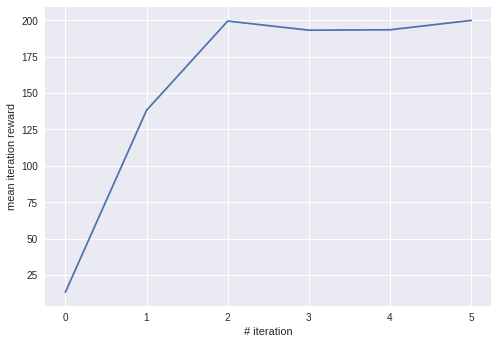

In [15]:
plt.plot(range(len(scores)), scores)
plt.xlabel("# iteration")
plt.ylabel("mean iteration reward")
plt.show()

100%|██████████| 200/200 [00:00<00:00, 305.34it/s]


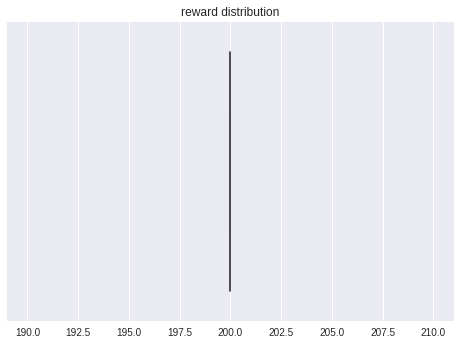

100%|██████████| 30/30 [00:33<00:00,  1.11s/it]

Best run (out of 30 sampled):
displaying './runs/CrossEntropy/0/rl-video-episode-0.mp4' run
reward: 200.0


In [16]:
! rm -rf ./runs/
video_folder, rewards = analyze_policy(env, cross_entropy, max_steps=200)

## Q-learning

## DQN

### Building a network

We now need to build a neural network that can map observations to state q-values.
The model does not have to be huge yet. 1-2 hidden layers with < 200 neurons and ReLU activation will probably be enough. Batch normalization and dropout can spoil everything here.

In [ ]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

In [ ]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        # Define your network body here. Please make sure agent is fully contained here
        assert len(state_shape) == 1
        state_dim = state_shape[0]
        <YOUR CODE>

        
    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch states, shape = [batch_size, *state_dim=4]
        """
        # Use your network to compute qvalues for given state
        qvalues = <YOUR CODE>

        assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"
        assert len(
            qvalues.shape) == 2 and qvalues.shape[0] == state_t.shape[0] and qvalues.shape[1] == n_actions

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [ ]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

Now let's try out our agent to see if it raises any errors.

In [ ]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [ ]:
evaluate(env, agent, n_games=1)

### Experience replay
For this assignment, we provide you with experience replay buffer. If you implemented experience replay buffer in previous bonus assigments, you can copy-paste it here in main notebook.

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [ ]:
from replay_buffer import ReplayBuffer
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(),
                   1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [ ]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    <YOUR CODE >

    return sum_rewards, s

In [ ]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]" % (
                                        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
        10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (
        10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (
        10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (
        10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"
    assert [
        0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions]"

print("Well done!")

### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png)

In [ ]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.


__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.

__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).

In [ ]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute V*(next_states) using predicted next q-values
    next_state_values = <YOUR CODE>

    assert next_state_values.dim(
    ) == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = <YOUR CODE>

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

Sanity checks

In [ ]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (
    ), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

### Main loop

It's time to put everything together and see if it learns anything.

In [ ]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
seed = <your favourite random seed>
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
env = make_env(seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

In [ ]:
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
             )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

In [ ]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 4 * 10**4
decay_steps = 1 * 10**4

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

max_grad_norm = 5000

In [ ]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

In [ ]:
state = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    < sample batch_size of data from experience replay >

    loss = < compute TD loss >

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm)

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        <YOUR CODE >

    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(evaluate(
            make_env(seed=step), agent, n_games=3, greedy=True, t_max=1000)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        plt.show()

In [ ]:
final_score = evaluate(
  make_env(),
  agent, n_games=30, greedy=True, t_max=1000
)
print('final score:', final_score)
assert final_score > 300, 'not good enough for DQN'
print('Well done')